# Fuzzywuzzy

In [1]:
import mwdsbe
import mwdsbe.datasets.licenses as licenses
import schuylkill as skool
import pandas as pd
import numpy as np
import time

In [2]:
registry = mwdsbe.load_registry() # geopandas df
license = licenses.CommercialActivityLicenses().download()

## Fuzzy match with score cutoff 95
##### Go directly to data analysis part to import saved matched data

In [3]:
# clean data
ignore_words = ['inc', 'group', 'llc', 'corp', 'pc', 'incorporated', 'ltd', 'co']
cleaned_registry = skool.clean_strings(registry, ['company_name', 'dba_name'], True, ignore_words)
cleaned_license = skool.clean_strings(license, ['company_name'], True, ignore_words)

In [5]:
t1 = time.time()
merged = (
    skool.fuzzy_merge(cleaned_registry, cleaned_license, on="company_name", score_cutoff=95)
    .pipe(skool.fuzzy_merge, cleaned_registry, cleaned_license, left_on="dba_name", right_on="company_name", score_cutoff=95)
)
t = time.time() - t1
matched = merged.dropna(subset=['company_name_y'])

Execution fuzzywuzzy match:  15.982689583301545  minute


In [6]:
print('Execution time:', t/60, 'min')

Execution time: 15.982689583301545 min


In [7]:
print('Fuzzywuzzy match:', len(matched), 'out of', len(cleaned_registry))

Fuzzywuzzy match: 1372 out of 3119


# Data Analysis for full dataset

## Matched Data

#### Import matched data stored before to save time

In [296]:
matched = pd.read_excel(r'C:\Users\dabinlee\Desktop\mwdsbe\data\full_fuzz_95.xlsx')

In [297]:
len(matched)

1372

In [298]:
active_companies = matched[matched.license_status == 'Active']
print('Active Companies:', len(active_companies), 'out of', len(matched))

Active Companies: 1359 out of 1372


In [299]:
instate_companies = matched[matched.location_state == 'PA']
print('In-state Companies:', len(instate_companies), 'out of', len(matched))

In-state Companies: 943 out of 1372


## Full Data

### Active Companies

In [14]:
len(license)

203543

In [15]:
unique_license = license.drop_duplicates(subset='company_name')
len(unique_license)

198347

In [16]:
full_active_companies = unique_license[unique_license.license_status == 'Active']
len(full_active_companies)

197193

### In-state companies

In [17]:
len(registry)

3119

##### TODO: find one duplicate company in registry

In [18]:
unique_registry = registry.drop_duplicates(subset='company_name')
len(unique_registry)

3118

To find one duplicate company... (set not working)

In [ ]:
set1 = set(registry['company_name'])

In [ ]:
set2 = set(unique_registry['company_name'])

In [ ]:
set1.difference(set2)

In [20]:
full_instate_companies = unique_registry[unique_registry.location_state == 'PA']
len(full_instate_companies)

1768

#### Is there any companies have multiple licenses?

In [44]:
license.head()

,license_num,issue_date,license_status,company_name
0,188053,1990-01-01T00:00:00Z,Active,BIRMINGHAM FIRE INS CO OF PA T
1,058781,1990-01-12T00:00:00Z,Active,CLAYMAN EDWARD P ESQ
2,057406,1990-01-23T00:00:00Z,Active,BRENNAN J F
3,332055,1990-02-08T00:00:00Z,Active,TASTY BAKING COMPANY
4,188058,1990-12-31T00:00:00Z,Active,MAGARGEE BROS INC


In [93]:
duplicate_companies = license[license.license_num.duplicated()]

In [94]:
multiple_licenses = duplicate_companies.groupby('company_name').size()

In [52]:
# total_licenses = license.groupby(['company_name', 'license_num']).size()

In [54]:
# total_licenses = total_licenses.groupby('company_name').size()

In [95]:
multiple_licenses = multiple_licenses.to_frame('N').reset_index()

In [102]:
n_multiple_licenses = len(multiple_licenses[multiple_licenses.N > 1])

In [103]:
print('Multiple Licenses:', n_multiple_licenses)

Multiple Licenses: 0


## sjoin matched and neighborhood

In [61]:
import geopandas as gpd

In [243]:
zillow = gpd.read_file('data/neighborhood/zillow_neighborhoods.geojson')
zillow = zillow.to_crs(epsg=3857)

In [244]:
zillow.head()

,ZillowName,geometry
0,Academy Gardens,POLYGON ((-8348795.676844054 4875297.327437355...
1,Airport,POLYGON ((-8370923.380392455 4850336.405079939...
2,Allegheny West,POLYGON ((-8367432.106275852 4866417.819736993...
3,Andorra,"POLYGON ((-8373967.120433775 4875663.02380158,..."
4,Aston Woodbridge,POLYGON ((-8349918.769724508 4873746.906470324...


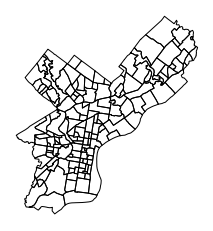

In [245]:
ax = zillow.plot(facecolor='none', edgecolor='black')
ax.set_axis_off()
ax.set_aspect("equal")
ax

In [394]:
# dropna geometry
matched = matched.dropna(subset=['geometry'])

In [251]:
# convert matched.geometry from string to wkt
from shapely import wkt
matched['geometry'] = matched['geometry'].apply(wkt.loads)

In [252]:
#convert matched dataframe to geodataframe
geo_matched = gpd.GeoDataFrame(matched, geometry='geometry', crs={"init": "epsg:4326"})

In [253]:
# convert crs 4326 to 3857
geo_matched = geo_matched.to_crs(epsg=3857)

In [254]:
joined = gpd.sjoin(geo_matched, zillow, op='within', how='left')

In [255]:
totals = joined.groupby('ZillowName').size()
totals = totals.to_frame('N').reset_index()

In [214]:
totals.head()

,ZillowName,N
0,Airport,1
1,Allegheny West,2
2,Aston Woodbridge,1
3,Bartram Village,1
4,Bella Vista,5


In [215]:
totals = zillow.merge(totals, on='ZillowName')

In [216]:
totals.head()

,ZillowName,geometry,N
0,Airport,POLYGON ((-8370923.380392455 4850336.405079939...,1
1,Allegheny West,POLYGON ((-8367432.106275852 4866417.819736993...,2
2,Aston Woodbridge,POLYGON ((-8349918.769724508 4873746.906470324...,1
3,Bartram Village,POLYGON ((-8372041.314282436 4856283.291900341...,1
4,Bella Vista,POLYGON ((-8366622.234939072 4857629.095753542...,5


### Visualize as choropleth map

1. plot the total number of compnaies per neighborhood.

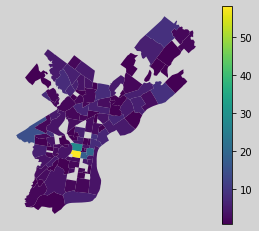

In [161]:
from matplotlib import pyplot as plt

# Create the figure/axes
fig, ax = plt.subplots(facecolor="lightgray") # use a gray background

# Plot
totals.plot(ax=ax, column="N", edgecolor="none", legend=True, cmap="viridis")

# Format
ax.set_axis_off()
ax.set_aspect("equal")

2. Better aesthetics - locatable axes

In [162]:
# Needed to line up the colorbar properly
from mpl_toolkits.axes_grid1 import make_axes_locatable

AttributeError: 'PatchCollection' object has no property 'cax'

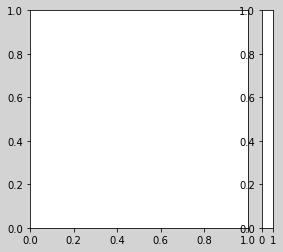

In [163]:
# Create the figure
fig, ax = plt.subplots(facecolor="lightgray")

# NEW: Create a nice, lined up colorbar axes (called "cax" here)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

# Plot
totals.plot(ax=ax, cax=cax, column="N", edgecolor="none", legend=True, cmap="viridis")

# NEW: Get the limits of the GeoDataFrame
xmin, ymin, xmax, ymax = totals.total_bounds

# NEW: Set the xlims and ylims
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

3. Quantiles Scheme

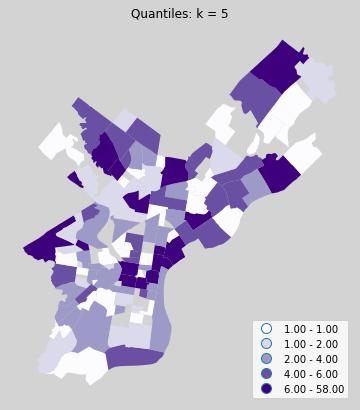

In [172]:
## Quantiles Scheme
fig, ax = plt.subplots(figsize=(10,7), facecolor='lightgray')
totals.plot(
    ax=ax,
    column="N",
    edgecolor="none",
    legend=True,
    legend_kwds=dict(loc='lower right'),
    cmap="Purples",
    scheme="Quantiles",
    k=5
)
ax.set_title("Quantiles: k = 5")
ax.set_axis_off()
ax.set_aspect("equal")

4. compare raw counts by normalizing by are

In [173]:
totals['N_per_area'] = totals['N'] / (totals.geometry.area)

In [174]:
totals.head()

,ZillowName,geometry,N,N_per_area
0,Airport,POLYGON ((-8370923.380392455 4850336.405079939...,1,6.090837e-08
1,Allegheny West,POLYGON ((-8367432.106275852 4866417.819736993...,2,3.919691e-07
2,Aston Woodbridge,POLYGON ((-8349918.769724508 4873746.906470324...,1,4.423720e-07
3,Bartram Village,POLYGON ((-8372041.314282436 4856283.291900341...,1,4.454682e-07
4,Bella Vista,POLYGON ((-8366622.234939072 4857629.095753542...,5,6.108412e-06


AttributeError: 'PatchCollection' object has no property 'cax'

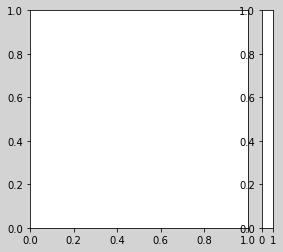

In [175]:
# Create the figure
fig, ax = plt.subplots(facecolor="lightgray")

# NEW: Create a nice, lined up colorbar axes (called "cax" here)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

# Plot
totals.plot(ax=ax, cax=cax, column="N_per_area", edgecolor="none", legend=True, cmap="viridis")

# NEW: Get the limits of the GeoDataFrame
xmin, ymin, xmax, ymax = totals.total_bounds

# NEW: Set the xlims and ylims
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

5. hexbin

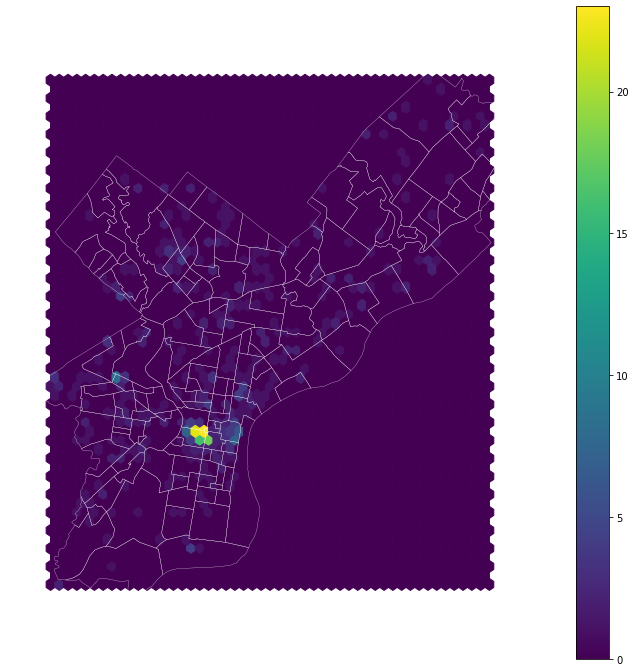

In [178]:
# create the axes
fig, ax = plt.subplots(figsize=(12, 12))

# use the .x and .y attributes
vals = ax.hexbin(geo_matched.geometry.x, geo_matched.geometry.y, gridsize=50)

# add the zillow geometry boundaries
zillow.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=0.25)

# add a colorbar and format
plt.colorbar(vals)
ax.set_axis_off()
ax.set_aspect("equal")

6. basemap

In [182]:
# city limits for Philadelphia
city_limits = gpd.read_file('./data/neighborhood/City_Limits')

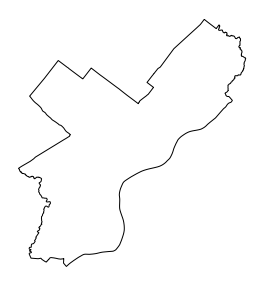

In [184]:
fig, ax = plt.subplots(figsize=(5, 5))
city_limits.to_crs(epsg=3857).plot(ax=ax, facecolor="none", edgecolor="black")

ax.set_axis_off()
ax.set_aspect("equal")

In [185]:
import contextily as ctx

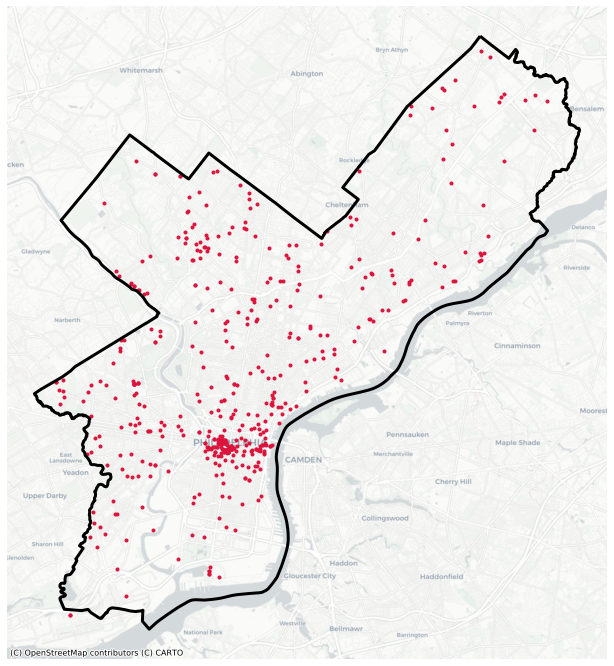

In [187]:
# create the axes
fig, ax = plt.subplots(figsize=(12, 12))

# plot a random sample of companies
geo_matched.plot(ax=ax, marker='.', color='crimson') # can use the sample() function

# add the city limits
city_limits.to_crs(geo_matched.crs).plot(ax=ax, edgecolor='black', linewidth=3, facecolor='none')

# NEW: plot the basemap underneath
ctx.add_basemap(ax=ax, crs=geo_matched.crs, url=ctx.providers.CartoDB.Positron)

# remove axis lines
ax.set_axis_off()

7. interactivity

In [188]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [189]:
totals.head()

,ZillowName,geometry,N,N_per_area
0,Airport,POLYGON ((-8370923.380392455 4850336.405079939...,1,6.090837e-08
1,Allegheny West,POLYGON ((-8367432.106275852 4866417.819736993...,2,3.919691e-07
2,Aston Woodbridge,POLYGON ((-8349918.769724508 4873746.906470324...,1,4.423720e-07
3,Bartram Village,POLYGON ((-8372041.314282436 4856283.291900341...,1,4.454682e-07
4,Bella Vista,POLYGON ((-8366622.234939072 4857629.095753542...,5,6.108412e-06


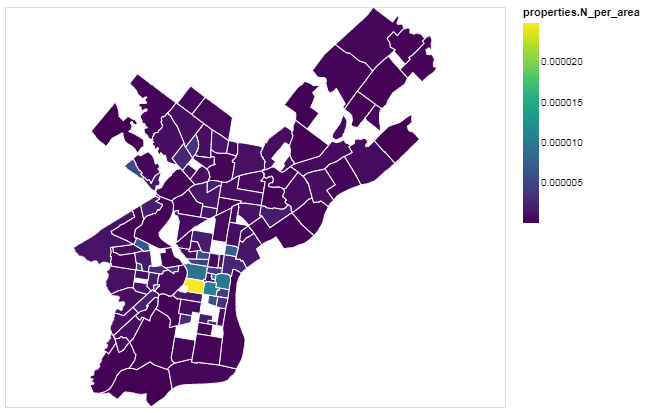

In [190]:
# create an altair data source from a GeoJSON representation
data = alt.InlineData(
    values=totals.to_crs(epsg=4326).to_json(),
    format=alt.DataFormat(property="features", type="json"),
)

# plot map, where variables ares nested within `properties`,
alt.Chart(data).mark_geoshape(stroke="white").properties(
    width=500, height=400, projection={"type": "mercator"}
).encode(
    tooltip=["properties.N_per_area:Q", "properties.ZillowName:N"],
    color=alt.Color("properties.N_per_area:Q", scale=alt.Scale(scheme='viridis'))
)

## Companies by neighborhoods

In [256]:
active = geo_matched[geo_matched.license_status == 'Active']

In [257]:
active_totals = joined[joined.license_status == 'Active']

In [258]:
active_totals = active_totals.groupby('ZillowName').size()
active_totals = active_totals.to_frame('N').reset_index()

In [261]:
active_totals = zillow.merge(active_totals, on='ZillowName')

In [277]:
active_totals.head()

,ZillowName,geometry,N,N_per_area
0,Airport,POLYGON ((-8370923.380392455 4850336.405079939...,1,6.090837e-08
1,Allegheny West,POLYGON ((-8367432.106275852 4866417.819736993...,2,3.919691e-07
2,Aston Woodbridge,POLYGON ((-8349918.769724508 4873746.906470324...,1,4.423720e-07
3,Bartram Village,POLYGON ((-8372041.314282436 4856283.291900341...,1,4.454682e-07
4,Bella Vista,POLYGON ((-8366622.234939072 4857629.095753542...,5,6.108412e-06


### Quantiles

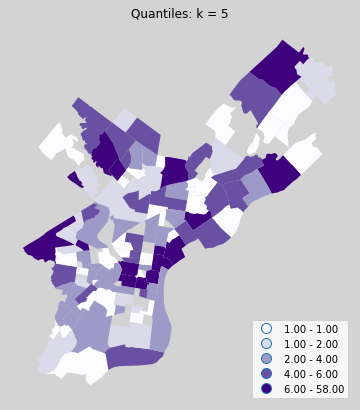

In [263]:
## Quantiles Scheme
fig, ax = plt.subplots(figsize=(10,7), facecolor='lightgray')
active_totals.plot(
    ax=ax,
    column="N",
    edgecolor="none",
    legend=True,
    legend_kwds=dict(loc='lower right'),
    cmap="Purples",
    scheme="Quantiles",
    k=5
)
ax.set_title("Quantiles: k = 5")
ax.set_axis_off()
ax.set_aspect("equal")

### Basemap

In [264]:
# city limits for Philadelphia
city_limits = gpd.read_file('./data/neighborhood/City_Limits')

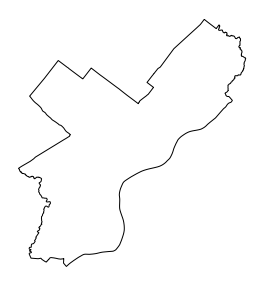

In [265]:
fig, ax = plt.subplots(figsize=(5, 5))
city_limits.to_crs(epsg=3857).plot(ax=ax, facecolor="none", edgecolor="black")

ax.set_axis_off()
ax.set_aspect("equal")

In [266]:
import contextily as ctx

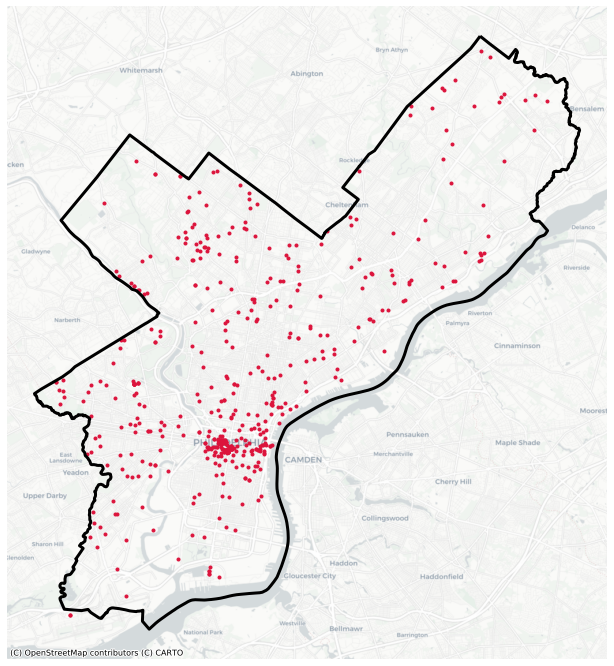

In [267]:
# create the axes
fig, ax = plt.subplots(figsize=(12, 12))

# plot companies
active.plot(ax=ax, marker='.', color='crimson') # can use the sample() function

# add the city limits
city_limits.to_crs(active.crs).plot(ax=ax, edgecolor='black', linewidth=3, facecolor='none')

# NEW: plot the basemap underneath
ctx.add_basemap(ax=ax, crs=active.crs, url=ctx.providers.CartoDB.Positron)

# remove axis lines
ax.set_axis_off()

### Interactivity

In [271]:
active_totals['N_per_area'] = active_totals['N'] / (active_totals.geometry.area)

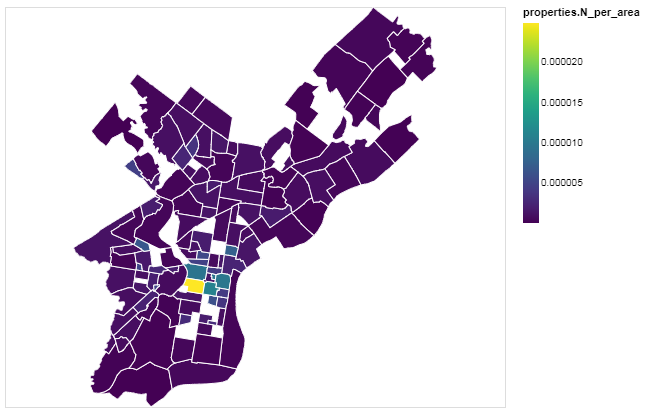

In [273]:
# create an altair data source from a GeoJSON representation
data = alt.InlineData(
    values=active_totals.to_crs(epsg=4326).to_json(),
    format=alt.DataFormat(property="features", type="json"),
)

# plot map, where variables ares nested within `properties`,
alt.Chart(data).mark_geoshape(stroke="white").properties(
    width=500, height=400, projection={"type": "mercator"}
).encode(
    tooltip=["properties.N_per_area:Q", "properties.ZillowName:N"],
    color=alt.Color("properties.N_per_area:Q", scale=alt.Scale(scheme='viridis'))
)

### Barchart - Top 5 neighborhoods with companies

In [274]:
import seaborn as sns

In [275]:
sns.set(style="whitegrid")

In [282]:
# Get top 5 neighborhoods
top_5 = active_totals.sort_values(by='N', ascending=False)[:5]

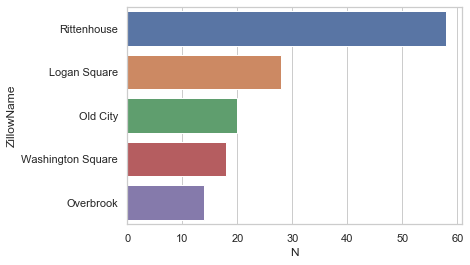

In [284]:
ax = sns.barplot(x="N", y="ZillowName", data=top_5)

## In-state companies

### Barchart

In [383]:
states = active_companies.groupby(['location_state']).size()

In [384]:
states = states.to_frame('N').reset_index()

In [385]:
states

,location_state,N
0,AZ,1
1,CA,12
2,CO,1
3,CT,3
4,DC,5
5,DE,31
6,FL,8
7,GA,11
8,IL,16
9,KS,1


In [386]:
others = states.loc[states['location_state'] != 'PA'].sum().to_frame().T

In [387]:
others.location_state[0] = 'Others'

In [388]:
pa = states.loc[states['location_state'] == 'PA']

In [389]:
binary_states = pd.concat([pa, other])

In [390]:
binary_states.location_state.iloc[0] = 'In-State'
binary_states.location_state.iloc[1] = 'Out-of-State'

In [391]:
binary_states

,location_state,N
24,In-State,937
0,Out-of-State,429


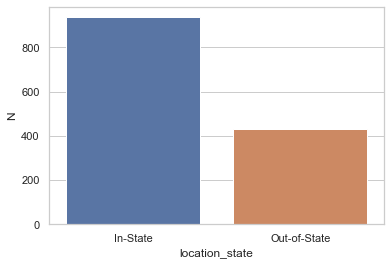

In [392]:
ax = sns.barplot(x="location_state", y="N", data=binary_states)